In [76]:
from nltk.corpus import wordnet as wn
import pandas as pd
import spacy
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from nltk.corpus.reader.wordnet import WordNetError
from nltk.stem import WordNetLemmatizer
from collections import Counter
sp = spacy.load('en_core_web_sm')
lemmatizer = WordNetLemmatizer()

In [162]:
[wn.synset(f'concern.n.{j}').definition() for j in range(4)]

['a commercial or industrial enterprise and the people who constitute it',
 'something that interests you because it is important or affects you',
 'an anxious feeling',
 'a feeling of sympathy for someone or something']

In [89]:
def find_pnouns(words):
    tw = ['someone who', 'people who', 'person who', ' man ', 'woman']
    doc = sp(" ".join(words))
    lst = [i for i in doc if i.pos_ in ['NOUN', 'PRON', 'PROPN']]
    total_pnouns = []
    for j in range(4):
        pnouns = []
        for i in lst:
            try: deft = wn.synset(f'{i}.n.0{j}').definition().lower()
            except WordNetError: continue
            keep = False
            for w in tw: 
                if w in deft: keep = True        
            if keep or (str(i).strip('s')[-3:] == 'ist'): 
                pnouns.append(str(i))
        total_pnouns.extend(pnouns)
    total_pnouns = list(set(total_pnouns))
    
    return [i for i in words if i in total_pnouns]

def classify(lst):
    persons, NORP, FAC_ORG, law = [], [], [], []
    for pair in lst:
        if pair[1] == 'PERSON': persons.append(pair[0])
        if pair[1] == 'NORP':   NORP.append(pair[0])
        if pair[1] in ['FAC', 'ORG']: FAC_ORG.append(pair[0])
        if pair[1] == 'LAW' or ('act' in pair[0].lower().split(' ')): law.append(pair[0])
    return persons, NORP, FAC_ORG, law

def classify_adjv(lst):
    if lst[0] == "": return [],[]
    lst = nltk.pos_tag(lst)
    adjv, verb = [], []
    
    for i in lst:
        try: lemmatizer.lemmatize(i[0])
        except IndexError: print(i)
        if i[1] in ['JJ', 'JJR', 'JJS', 'RB', 'RBR', 'RBS']: 
            adjv.append(lemmatizer.lemmatize(i[0]))
        if 'VB' in i[1]: verb.append(lemmatizer.lemmatize(i[0]))
    return adjv, verb

In [72]:
def word_frequency(target, name):
    previous = range(2010, 2012)
    after = range(2017, 2019)
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    cut = data[data['Year'].isin(previous)]
    words = Counter(cut[target].sum())
    [words.pop(i) for i in list(words.keys()) if len(i)<2]
    words = sorted(words.items(), key=lambda k: -k[1])[:20]
    
    sns.barplot(y=[i[0] for i in words], x=[i[1] for i in words], 
                palette = ("Blues_d"), ax=axes[0])
    
    cut = data[data['Year'].isin(after)]
    words = Counter(cut[target].sum())
    [words.pop(i) for i in list(words.keys()) if len(i)<2]
    words = sorted(words.items(), key=lambda k: -k[1])[:20]
    
    sns.barplot(y=[i[0] for i in words], x=[i[1] for i in words], 
                palette = ("Blues_d"), ax=axes[1])
    
    axes[0].set_title(f'2010-2012', fontsize= 8)
    axes[1].set_title(f'2017-2019', fontsize= 8)
    fig.suptitle(f'Word Frequency for {name}', fontsize=15)
    fig.tight_layout(pad=4.0)
    
    plt.show()

In [146]:
data = pd.read_csv('data/heritage_token.csv')
sent_transform = lambda x: [[j.strip("\'") for j in i.split("', '")] for i in 
                             x.strip('[|]').split("'], ['")]
data['sent_token'] = data['sent_token'].apply(sent_transform)
data['word_token'] = data['word_token'].apply(lambda x: x.strip("[|]|'").split("', '"))

data['pnouns'] = data['word_token'].apply(find_pnouns) ## find person nouns

In [147]:
ent = [] ## all the below, find different types of nouns
max_length = data.shape[0]
for ind, text in enumerate(data['text']):
    print(round(ind/max_length, 4), end = '\r')
    ent.append(sp(text))

In [148]:
data['ent'] = ent
labels = data['ent'].apply(lambda n: [(j.text, j.label_) for x in n.sents 
                                      for j in x.ents])
results = [classify(i) for i in labels]
data["persons"] = [i[0] for i in results]
data["NORP"]    = [i[1] for i in results]
data["FAC_ORG"] = [i[2] for i in results]
data["law"]     = [i[3] for i in results]

results = [classify_adjv(i) for i in data['word_token']]
data["adjv"] = [i[0] for i in results]
data["verb"] = [i[1] for i in results]

In [151]:
data = data.drop(['text', 'sent_token', 'word_token'], axis=1)

In [152]:
data.to_csv('data/heritage_classified.csv', index=False)

## Reload Data

### Daily Signal

In [142]:
data = pd.read_csv('data/sig_classified.csv')

data['len'] = data['word_token'].apply(lambda x: len(x))
data = data[data['len']>10]

for i in ["pnouns", "NORP", "FAC_ORG", "law", "verb"]:
    data[i] = data[i].apply(lambda x: x.strip("[|]|'").split("', '") if len(x)>0 else x)
    
data["law"] = data["law"].apply(lambda x: [i if (i.split(' ')[0] != 'the') 
                                           else ' '.join(i.split(' ')[1:]) for i in x])

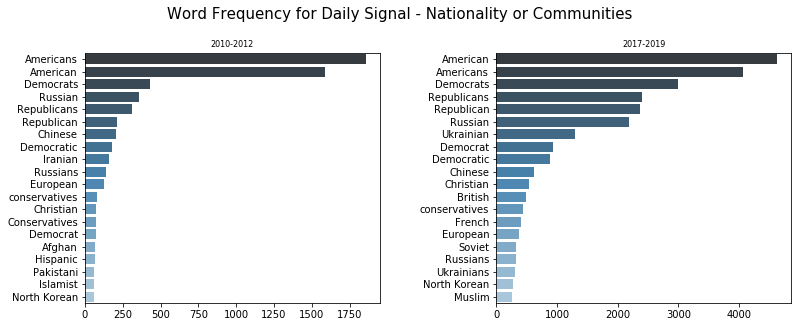

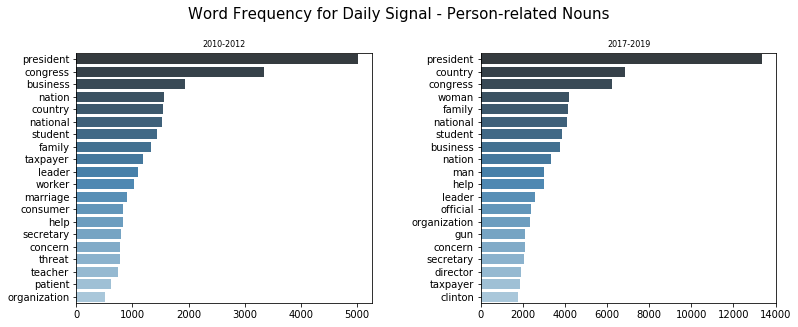

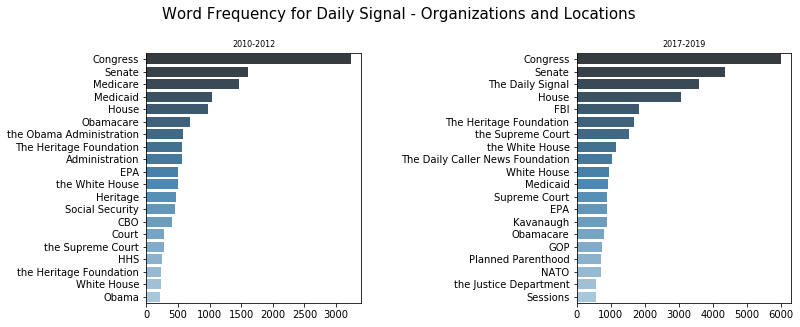

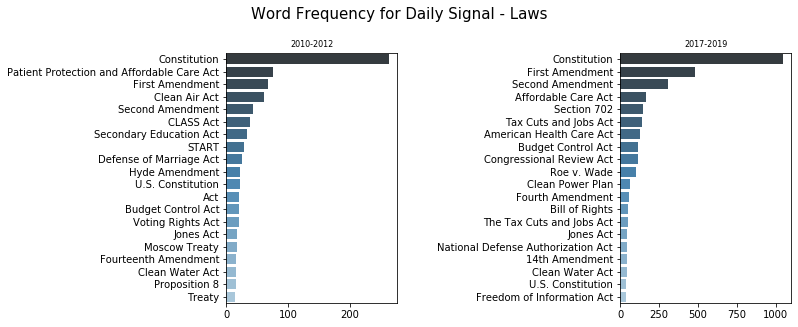

In [143]:
# pnouns, NORP, FAC_ORG, law, verb
name = 'Daily Signal'
word_frequency('NORP', f'{name} - Nationality or Communities')
word_frequency('pnouns', f'{name} - Person-related Nouns')
word_frequency('FAC_ORG', f'{name} - Organizations and Locations')
word_frequency('law', f'{name} - Laws')

In [140]:
data = pd.read_csv('data/aei_classified.csv')

data['len'] = data['word_token'].apply(lambda x: len(x))
data = data[data['len']>10]

for i in ["pnouns", "NORP", "FAC_ORG", "law", "verb"]:
    data[i] = data[i].apply(lambda x: x.strip("[|]|'").split("', '") if len(x)>0 else x)
    
data["law"] = data["law"].apply(lambda x: [i if (i.split(' ')[0] != 'the') 
                                           else ' '.join(i.split(' ')[1:]) for i in x])

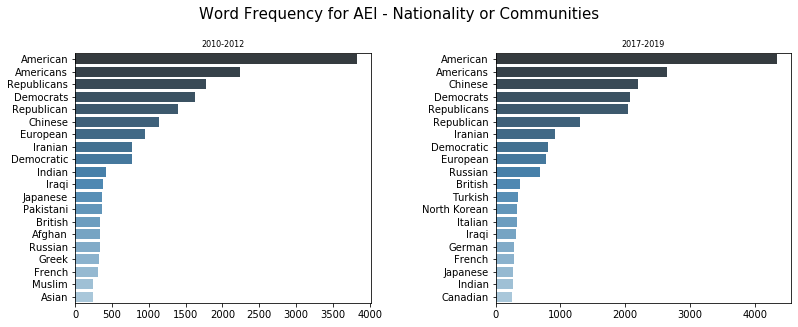

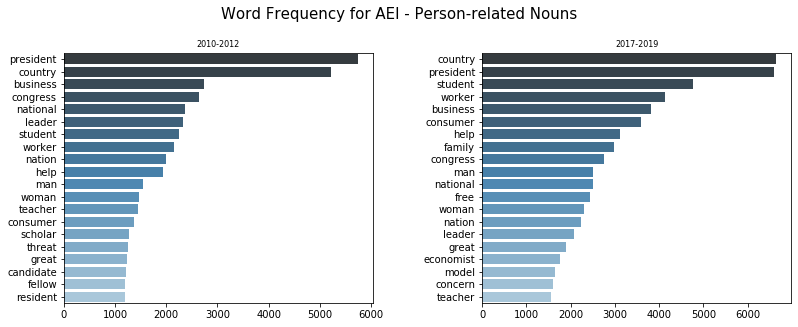

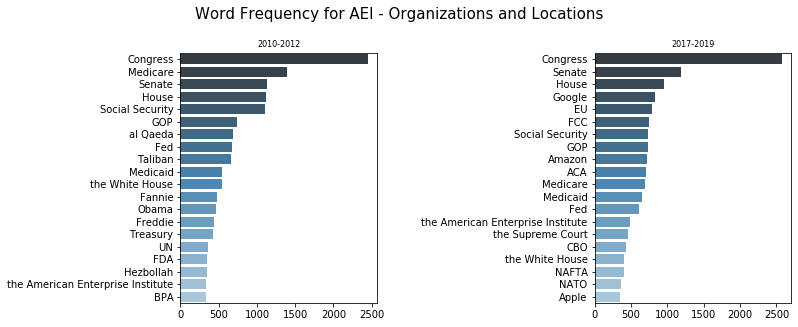

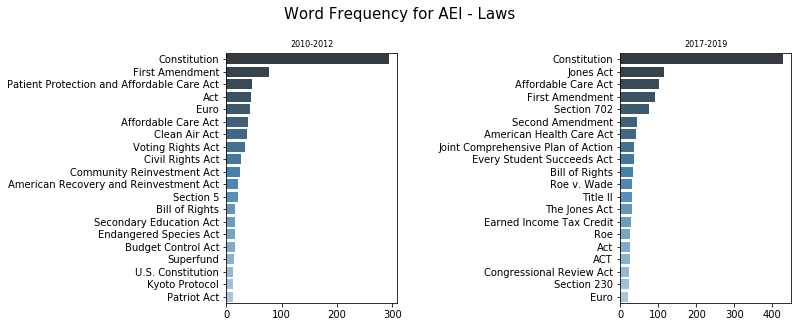

In [141]:
name = 'AEI'
word_frequency('NORP', f'{name} - Nationality or Communities')
word_frequency('pnouns', f'{name} - Person-related Nouns')
word_frequency('FAC_ORG', f'{name} - Organizations and Locations')
word_frequency('law', f'{name} - Laws')

In [ ]:
data = pd.read_csv('data/heritage_classified.csv')

data['len'] = data['word_token'].apply(lambda x: len(x))
data = data[data['len']>10]

for i in ["pnouns", "NORP", "FAC_ORG", "law", "verb"]:
    data[i] = data[i].apply(lambda x: x.strip("[|]|'").split("', '") if len(x)>0 else x)
    
data["law"] = data["law"].apply(lambda x: [i if (i.split(' ')[0] != 'the') 
                                           else ' '.join(i.split(' ')[1:]) for i in x])

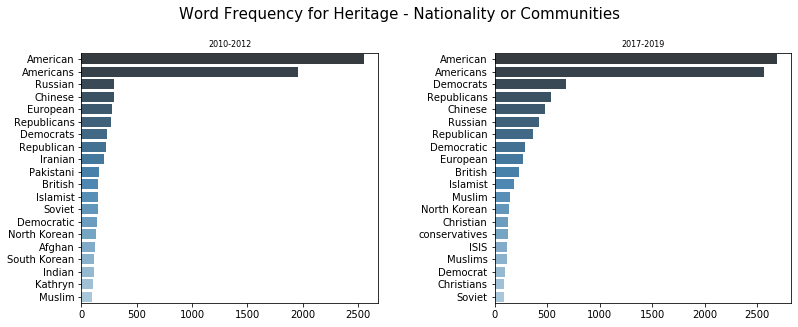

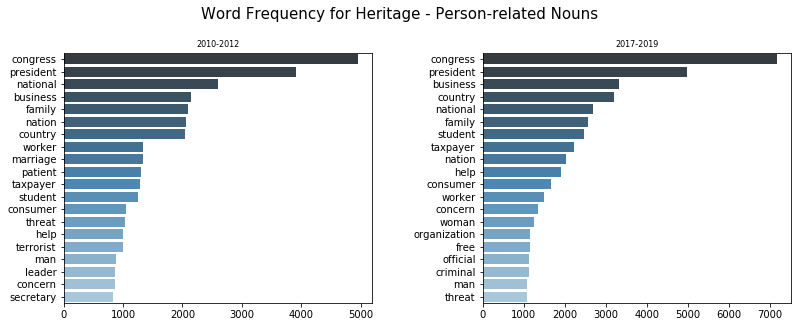

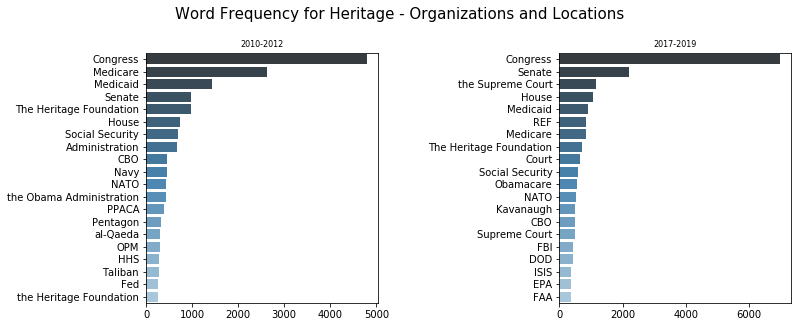

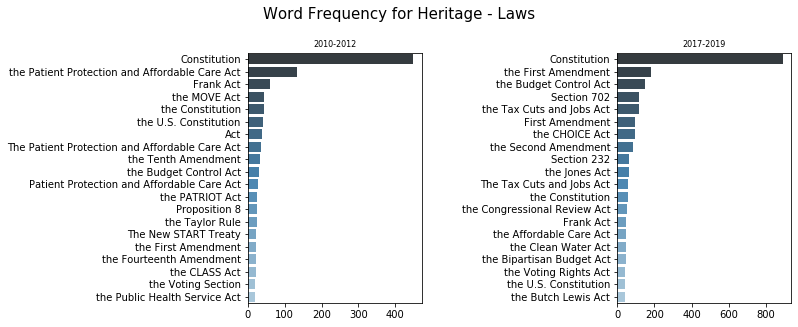

In [153]:
name = 'Heritage'
word_frequency('NORP', f'{name} - Nationality or Communities')
word_frequency('pnouns', f'{name} - Person-related Nouns')
word_frequency('FAC_ORG', f'{name} - Organizations and Locations')
word_frequency('law', f'{name} - Laws')